<a href="https://colab.research.google.com/github/JWackerow/Loan-Prediction/blob/main/Loan_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

**EDA**

In [4]:
# look at the data
train.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
# Missing values in train data
missing_train = pd.concat([train.isna().sum(), round(100 * train.isna().sum()/len(train), 2)], axis=1).rename({0: '# Missing', 1: '% Missing'}, axis=1)
missing_train.loc[missing_train['# Missing'] != 0].sort_values(by='# Missing', ascending=False)

,# Missing,% Missing
Credit_History,50,8.14
Self_Employed,32,5.21
LoanAmount,22,3.58
Dependents,15,2.44
Loan_Amount_Term,14,2.28
Gender,13,2.12
Married,3,0.49


In [6]:
# Missing values in test data
missing_test = pd.concat([test.isna().sum(), round(100 * test.isna().sum()/len(test), 2)], axis=1).rename({0: '# Missing', 1: '% Missing'}, axis=1)
missing_test.loc[missing_test['# Missing'] != 0].sort_values(by='# Missing', ascending=False)

,# Missing,% Missing
Credit_History,29,7.90
Self_Employed,23,6.27
Gender,11,3.00
Dependents,10,2.72
Loan_Amount_Term,6,1.63
LoanAmount,5,1.36


In [ ]:
# class distribution
train.Loan_Status.value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

In [ ]:
# class distribution with missing credit history
train[train.Credit_History.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.74
N    0.26
Name: Loan_Status, dtype: float64

In [ ]:
# class distribution without missing credit history
train[train.Credit_History.isna() == False]['Loan_Status'].value_counts(normalize=True)

Y    0.682624
N    0.317376
Name: Loan_Status, dtype: float64

In [ ]:
# class distrubution where credit history equals 0
train[train['Credit_History'] == 0]['Loan_Status'].value_counts(normalize=True)

N    0.921348
Y    0.078652
Name: Loan_Status, dtype: float64

In [ ]:
# class distrubution where credit history equals 1
train[train['Credit_History'] == 1]['Loan_Status'].value_counts(normalize=True)

Y    0.795789
N    0.204211
Name: Loan_Status, dtype: float64

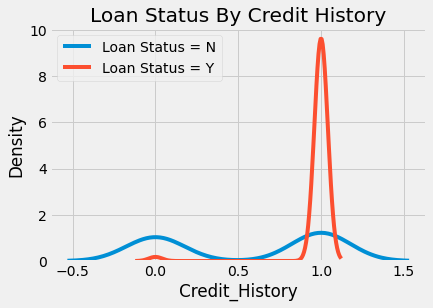

In [19]:
plt.style.use('fivethirtyeight')

sns.kdeplot(train.loc[train.Loan_Status == 'N', 'Credit_History'], label='Loan Status = N')
sns.kdeplot(train.loc[train.Loan_Status == 'Y', 'Credit_History'], label='Loan Status = Y')

plt.title('Loan Status By Credit History')
plt.legend()
plt.show()

In [ ]:
# class distribution with missing self employment data
train[train.Self_Employed.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.71875
N    0.28125
Name: Loan_Status, dtype: float64

In [ ]:
# class distribution with missing loan amount
train[train.LoanAmount.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.5
N    0.5
Name: Loan_Status, dtype: float64

In [ ]:
# Mean loan amount by class
print('Loan status Y loan amount: ', train[train.Loan_Status == 'Y']['LoanAmount'].mean())
print('Loan status N loan amount: ', train[train.Loan_Status == 'N']['LoanAmount'].mean())

Loan status Y loan amount:  144.29440389294405
Loan status N loan amount:  151.22099447513813


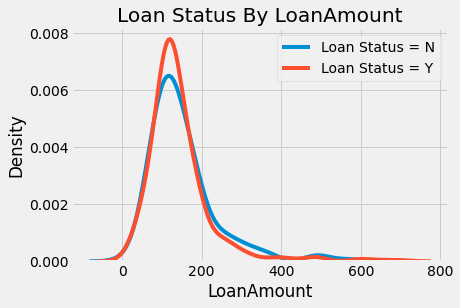

In [20]:
sns.kdeplot(train.loc[train.Loan_Status == 'N', 'LoanAmount'], label='Loan Status = N')
sns.kdeplot(train.loc[train.Loan_Status == 'Y', 'LoanAmount'], label='Loan Status = Y')

plt.title('Loan Status By LoanAmount')
plt.legend()
plt.show()

In [ ]:
# class distribution with missing dependents
train[train.Dependents.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.6
N    0.4
Name: Loan_Status, dtype: float64

In [ ]:
# class distribution with missing loan amount term
train[train.Loan_Amount_Term.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.571429
N    0.428571
Name: Loan_Status, dtype: float64

In [ ]:
# class distribution with missing gender
train[train.Gender.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.615385
N    0.384615
Name: Loan_Status, dtype: float64

In [ ]:
# class distribution with missing marital status
train[train.Married.isna()]['Loan_Status'].value_counts(normalize=True)

Y    1.0
Name: Loan_Status, dtype: float64

**Missing Value Imputation**

In [ ]:
train.LoanAmount.describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

In [ ]:
pd.cut(train.LoanAmount, bins=7).value_counts()

(107.714, 206.429]    339
(8.309, 107.714]      177
(206.429, 305.143]     48
(305.143, 403.857]     14
(403.857, 502.571]      9
(502.571, 601.286]      3
(601.286, 700.0]        2
Name: LoanAmount, dtype: int64

In [ ]:
train.Loan_Amount_Term.value_counts(normalize=True)

360.0    0.853333
180.0    0.073333
480.0    0.025000
300.0    0.021667
84.0     0.006667
240.0    0.006667
120.0    0.005000
36.0     0.003333
60.0     0.003333
12.0     0.001667
Name: Loan_Amount_Term, dtype: float64

In [ ]:
train.Married.value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [ ]:
train.Dependents.value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [139]:
def impute_missing_values(train, test):
  """
  Fills missing values in the dataframe
  """
  # fills credit history
  train.loc[train.Credit_History.isna(), "Credit_History"] = 2
  train.Credit_History = train.Credit_History.replace({0.0: 'Credit_No', 1.0: 'Credit_Yes', 2.0: 'Credit_Missing'})
  test.loc[test.Credit_History.isna(), "Credit_History"] = 2
  test.Credit_History = test.Credit_History.replace({0.0: 'Credit_No', 1.0: 'Credit_Yes', 2.0: 'Credit_Missing'})

  # fills self employed
  train.loc[train.Self_Employed.isna(), "Self_Employed"] = 'Self_Employed_Missing'
  train.loc[train.Gender.isna(), 'Gender'] = "Gender_Missing"
  test.loc[test.Self_Employed.isna(), "Self_Employed"] = 'Self_Employed_Missing'
  test.loc[test.Gender.isna(), 'Gender'] = "Gender_Missing"
  
  # fills married, there were no missing values in test
  train.loc[train.Married.isna(), 'Married'] = train.Married.mode()[0]
  
  # fills dependents
  train.loc[train.Dependents.isna(), 'Dependents'] = train.Dependents.mode()[0]
  test.loc[test.Dependents.isna(), 'Dependents'] = train.Dependents.mode()[0]
  
  # since there are outliers, we use median to fill here
  train.loc[train.LoanAmount.isna(), 'LoanAmount'] = train.LoanAmount.median()
  test.loc[test.LoanAmount.isna(), 'LoanAmount'] = train.LoanAmount.median()

  # fill loan amount (mode is also 360)
  train.loc[train.Loan_Amount_Term.isna(), 'Loan_Amount_Term'] = train.Loan_Amount_Term.median()
  test.loc[test.Loan_Amount_Term.isna(), 'Loan_Amount_Term'] = train.Loan_Amount_Term.median()
  
  return train, test

In [140]:
# impute missing values for train and test data
train, test = impute_missing_values(train, test)

In [141]:
# Drop ID column in both train and test data
train_ids = train['Loan_ID']
train = train.drop(columns=['Loan_ID'], axis=1)

test_ids = test['Loan_ID']
test = test.drop(columns=['Loan_ID'], axis=1)

In [142]:
train.shape, test.shape

((614, 12), (367, 11))

In [143]:
# confirm no missing value remain
print(train.isna().sum())
print(test.isna().sum())

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


**Encode Variables**

In [144]:
def encode_features(train, test):
  # Use OneHotEncoder to encode categorical features
  cat_features = list(c for c in train.select_dtypes([object]).columns if c not in ["Dependents", "Loan_Status"])
  ohe = OneHotEncoder(handle_unknown="ignore")

  train_ohe = ohe.fit_transform(train[cat_features]).toarray()
  test_ohe = ohe.fit_transform(test[cat_features]).toarray()
  # Replace categorical features with encoded columns
  train = pd.concat(objs=[train.drop(columns=cat_features, axis=1), pd.DataFrame(train_ohe)], axis=1)  
  test = pd.concat(objs=[test.drop(columns=cat_features, axis=1), pd.DataFrame(test_ohe)], axis=1)  

  le = LabelEncoder()
  
  # Use LabelEncoder to encode class labels in training data
  #train.Loan_Status = le.fit_transform(train.Loan_Status)
  
  # Use LabelEncoder to encode the number of dependents
  train.Dependents =  le.fit_transform(train.Dependents)
  test.Dependents =  le.transform(test.Dependents)

  return train, test

In [145]:
train, test = encode_features(train, test)

In [146]:
train.head(2)

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,5849,0.0,128.0,360.0,Y,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,4583,1508.0,128.0,360.0,N,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


**Review For Outliers**

In [64]:
train.ApplicantIncome.describe()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

[]

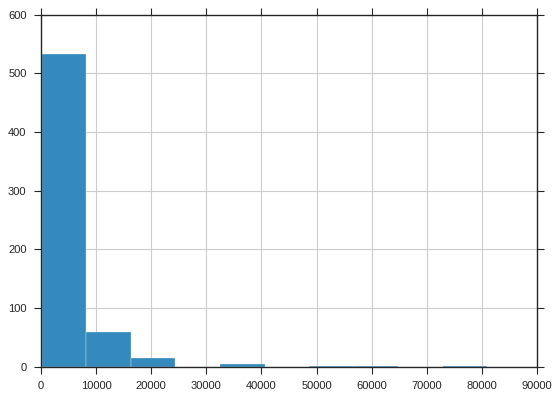

In [86]:
plt.style.use('seaborn-notebook')
train.ApplicantIncome.hist().plot()

In [87]:
train.loc[train.ApplicantIncome > 40000]

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
171,3,51763,0.0,700.0,300.0,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
333,0,63337,0.0,490.0,180.0,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
409,3,81000,0.0,360.0,360.0,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [88]:
train.CoapplicantIncome.describe()

count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64

[]

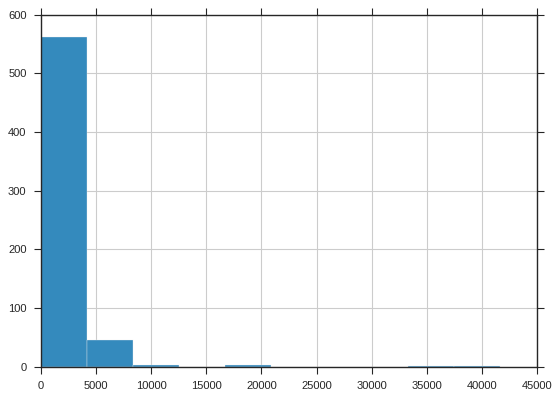

In [89]:
train.CoapplicantIncome.hist().plot()

In [90]:
train.loc[train.CoapplicantIncome > 15000]

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
402,0,2500,20000.0,103.0,360.0,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
417,2,1600,20000.0,239.0,360.0,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
581,0,1836,33837.0,90.0,360.0,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
600,3,416,41667.0,350.0,180.0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [91]:
train.LoanAmount.describe()

count    614.000000
mean     145.752443
std       84.107233
min        9.000000
25%      100.250000
50%      128.000000
75%      164.750000
max      700.000000
Name: LoanAmount, dtype: float64

[]

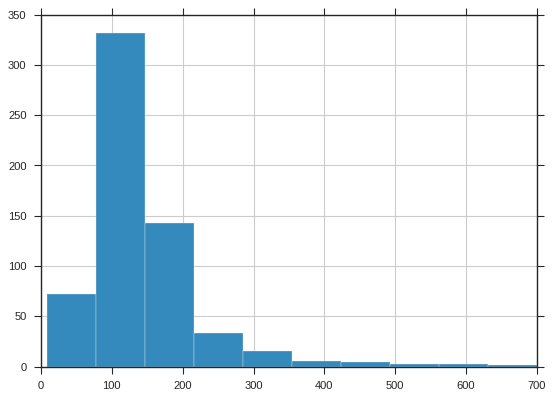

In [92]:
train.LoanAmount.hist().plot()

In [93]:
train.loc[train.LoanAmount > 500]

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
130,0,20166,0.0,650.0,480.0,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
155,3,39999,0.0,600.0,180.0,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
171,3,51763,0.0,700.0,300.0,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
369,0,19730,5266.0,570.0,360.0,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
561,1,19484,0.0,600.0,360.0,1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


[]

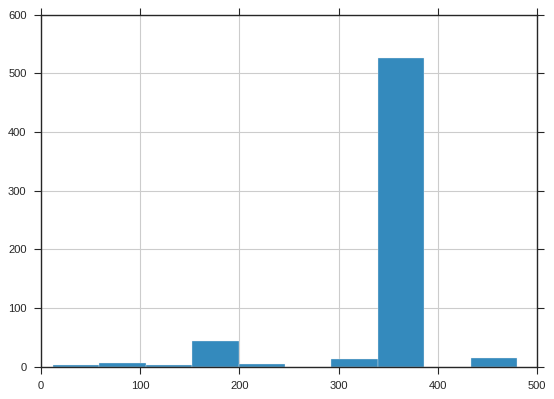

In [94]:
train.Loan_Amount_Term.hist().plot()

**Scale Data**

In [147]:
# Since we have outliers, I', using the RobustScaler
robust_scaler = RobustScaler()
train.iloc[:, 1:5] = robust_scaler.fit_transform(train.iloc[:, 1:5])
test.iloc[:, 1:5] = robust_scaler.transform(test.iloc[:, 1:5])

**Build Ensemble Model**

In [148]:
# split training data
# create a single variable to set random state
rs = 1
y = train['Loan_Status'].values
X = train.drop(columns=['Loan_Status'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=rs)

In [149]:
ensemble = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=rs)), ('rf', RandomForestClassifier(random_state=rs)), ('svm', SVC(random_state=rs)), ('knn', KNeighborsClassifier()), ('xgb', XGBClassifier(random_state=rs))], n_jobs=-1)

In [150]:
param_grid = {'lr__C' : [.8, 1, 1.2], 'svm__C': [.6, .8, 1, 1.2], 'knn__n_neighbors':[3, 5, 7]}

In [151]:
# find best parameters using grid search
grid = GridSearchCV(estimator=ensemble, param_grid=param_grid, scoring='f1_micro', n_jobs=-1)

In [152]:
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=VotingClassifier(estimators=[('lr',
                                                     LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                           

In [153]:
print(grid.best_params_)

{'knn__n_neighbors': 7, 'lr__C': 0.8, 'svm__C': 0.6}


In [154]:
ensemble = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=rs, C=grid.best_params_['lr__C'])), ('rf', RandomForestClassifier(random_state=rs)), ('svm', SVC(random_state=rs, C=grid.best_params_['svm__C'])), ('knn', KNeighborsClassifier(n_neighbors=grid.best_params_['knn__n_neighbors'])), ('xgb', XGBClassifier(random_state=rs))], n_jobs=-1)

In [155]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.8, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1, solver='lbfgs',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                

In [156]:
# get test accuracy
ensemble.score(X_test, y_test)

0.7967479674796748